In `STA410_W24_Week2_Lecture_Estimation.ipynb` we considered 
(a posterior distribution) $p(\theta|\mathbf{x}) = \text{Beta}(2,2)$ and examined computing the posterior probability

$$\Pr(0.95 < \theta < 0.99 | \mathbf{x}) = E_{\theta|\mathbf{x}}[1_{[.95,.99]}(\theta)] = \int 1_{[.95, .99]}(\theta) p(\theta|\mathbf{x}) d\theta$$

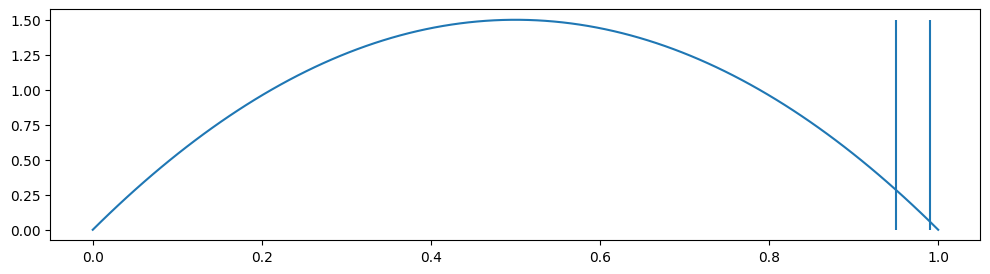

In [6]:
import matplotlib.pyplot as plt; from scipy import stats; import numpy as np
support = np.linspace(0,1,100); plt.figure(figsize=(12,3)); plt.plot(support, stats.beta(2,2).pdf(support), label="Beta(2,2)"); plt.vlines([.95,.99], ymin=0, ymax=1.5);

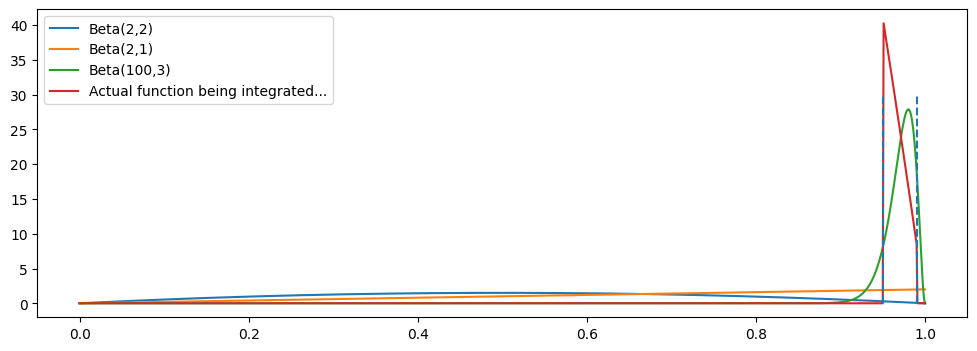

In [7]:
import matplotlib.pyplot as plt; from scipy import stats; import numpy as np
def region(x, a=.95,b=.99): return (x>a)&(x<b)
support = np.linspace(0,1,1000); plt.figure(figsize=(12,4)); plt.plot(support, stats.beta(2,2).pdf(support), label="Beta(2,2)"); plt.plot(support, stats.beta(2,1).pdf(support), label="Beta(2,1)"); plt.plot(support, stats.beta(100,3).pdf(support), label="Beta(100,3)"); plt.plot(support, stats.beta(2,2).pdf(support)*region(support)/(stats.beta(2,2).cdf(.99)-stats.beta(2,2).cdf(.95)), label="Actual function being integrated..."); plt.vlines([.95,.99], linestyle='dashed', ymin=0, ymax=30); plt.legend()

In [8]:
X = stats.beta(2,2); tilde_X = stats.beta(2,1); #tilde_X = stats.beta(100,3)
n = 1000; x = X.rvs(size=n); tilde_x = tilde_X.rvs(size=n) 
w_ = X.pdf(tilde_x)/tilde_X.pdf(tilde_x); w = w_/w_.sum() 
def region(x, a=.95,b=.99):
  return (x>a)&(x<b)
print("The Analytical Truth is:", np.round(X.cdf(.99)-X.cdf(.95), 5)); 
print("Naive Beta(2,2) Samples:", np.mean(region(x)), end=' '); 
print("  (SE:", np.round((np.var(region(x))/n)**0.5, 5), end=')\n')
print("    Importance Sampling:", np.round(np.mean(region(tilde_x)*w_),5), end=' '); 
print("(SE:", np.round((np.var(region(tilde_x)*w_)/n)**0.5, 5), end=')\n')
print("Importance Sampling(V2):", np.round((w*region(tilde_x)).sum(),5), end=' ')
print("(SE:", np.round( (((w*(region(tilde_x)-(w*region(tilde_x)).sum()))**2).sum())**0.5, 5), end=')\n')
print("(Normalized Weights)") 
# NOT (np.var(region(tilde_x))*(w**2).sum())**0.5 as in https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
# -> sum_i g(x_i)*(w_i/sum(w_)) is a ratio of random variables: https://artowen.su.domains/mc/Ch-var-is.pdf

The Analytical Truth is: 0.00695
Naive Beta(2,2) Samples: 0.014   (SE: 0.00372)
    Importance Sampling: 0.00566 (SE: 0.00072)
Importance Sampling(V2): 0.00577 (SE: 0.00079)
(Normalized Weights)


When estimating the integral using ***importance sampling***

\begin{align*}
\int g(x) p(x) dx & = {} \int g(x) \frac{p(x)}{\tilde p(x)} \tilde p(x) dx\\
E_{p(x)}[g(x)] & = {} E_{\tilde p(x)}\left[g(x) \frac{p(x)}{\tilde p(x)} \right]
\end{align*}

the prescribed estimator is actually

$$\overline{W^* Y} =  \underbrace{\frac{\sum_{i=1}^n W_i^* Y_i}{n}}_{E_{\tilde p(x)}[W_i^*]=1} \quad \text{ as opposed to } \quad \overline{Y} = \underbrace{\sum_{i=1}^n W_i Y_i}_{E_{\tilde p(x)}[W_i]=\frac{1}{n}}$$

$$\text{where } \quad Y_i = g(\tilde X_i) \quad \tilde X_i \sim \tilde p(x) \quad  W_i^* = \frac{p(\tilde X_i)}{\tilde p(\tilde X_i)} \quad W_i = \frac{ W_i^*}{\sum_{i=1}^n  W_i^*}$$

The former estimator is "recommended" because the latter is slighly biased since it can be shown that

$$E[\overline{W^* Y}] =  E_{p(x)}[g(x)] \quad \text{ but } \quad E[\overline{Y}] = E[\overline{W^* Y}] \left(1 + \frac{1}{n}Var(W_i^*)\right) - \frac{1}{n}Cov(W_i^*Y_i, W_i^*) + \mathcal{O}(n^{-2})$$

However, the bias can be estimated (and adjusted) with $\widehat{\text{Var}}(W_i^*)$ and $\widehat{\text{Cov}}(W_i^*Y_i, W_i^*)$; and, it can additionally be shown that the ***mean squared error*** 

$$\text{E}[(\overline{Y} - \text{E}[\overline{Y}])^2] = \text{Var}(\overline{Y}) + \text{bias}[\overline{Y}]^2 <  MSE(\overline{W^* Y})$$

whenever

$$\quad \text{ whenever } \quad \text{Cor}(W_i^*Y_i, W_i^*) > \frac{\text{cv}(W^*_i)}{2\text{cv}(Y_i)}$$

where, e.g., $\text{cv}(Y_i) = \frac{\sigma_{Y_i}}{\mu_{Y_i}}$ is the ***coefficient of variation***.

In [18]:
var_wy, cov_wy_w, cov_wy_w, var_w = np.cov(w_*region(tilde_x), w_).flatten()
mean_wy, mean_w = np.mean(w_*region(tilde_x)), np.mean(w_)
print("Multiplicative Bias", "=", (1+var_w/n), '-', cov_wy_w/n, '+ O(', n**-2, ')\n')

print("But now,if")
print("\ncor(YW*, W*)", cov_wy_w/(np.sqrt(var_wy*var_w)))
print(">")
print("cv(W*)/(2cv(YW*)", (np.sqrt(var_w)/mean_w)/(2*np.sqrt(var_wy)/mean_wy))
print("?\n\nthen Normalizied Importance Sampling will have\nsmaller MSE than (standard normal) Importance Sampling")

Multiplicative Bias = 1.0004920271704691 - -5.007985569150336e-06 + O( 1e-06 )

But now,if

cor(YW*, W*) -0.31170705021026585
>
cv(W*)/(2cv(YW*) 0.08829762755691233
?

then Normalizied Importance Sampling will have
smaller MSE than (standard normal) Importance Sampling


> Returning to our two estimators $\overline{W^* Y}$ and $\overline{Y}$, for the two samples 
> 
> 1. $\{X_i = x_i: \; X_i \sim p(x) \text{ for } i=1,\cdots, n\}$ 
> 
> 2. $\{\tilde X_i = \tilde x_i: \; \tilde X_i \sim \tilde p( \tilde x) \text{ for } i=1,\cdots, n\}$
> 
> and two sets of weights
> 1. $\left\{w_i^* = \frac{p(x_i)}{\tilde p(x_i)} : i=1,\cdots, n \right\}$ 
> 2. $\left\{w_i = \frac{w_i^*}{\sum_{i=1}^n w_i^*} : i=1,\cdots, n \right\}$
> 
> the three estimands
> 
> 1. $\overline{g(x)} = \frac{\sum_{i=1}^n g(x_i)}{n} $
> 2. $\overline{w^*y}= \frac{\sum_{i=1}^n w_i^*y_i}{n}\quad \text{ where } \quad  y_i= g(\tilde x_i)$
> 3. $\bar y = \sum_{i=1} w_i y_i \quad \text{ and still } \quad y_i= g(\tilde x_i) $
> 
> all estimate $\displaystyle \int \!\! g(x) p(x) dx = \int \!\! g(x) \frac{p(x)}{\tilde p(x)} \tilde p(x) dx$ and have estimated sample variances 
> 
> 1. $\hat \sigma^2_p = \frac{1}{n}\frac{\sum_{i=1}^n(g(x_i)-\overline{g(x)})^2}{n-1}$
> 2. $\hat \sigma^2_{\tilde p} = \frac{1}{n}\frac{\sum_{i=1}^n(w_i^*y_i-\overline{w^*y})^2}{n-1}$
> 3. $\hat \sigma^2_{w} = \sum_{i=1}^n w_i^2 (y_i - \bar y)^2$
> 
> with 
> 
> - $\hat \sigma^2_{\tilde p} < \hat \sigma^2_{p}$ if relative sampling correction factor $w_i^* = \frac{p(\tilde x_i)}{\tilde p(\tilde x_i)}$ tends to be larger (smaller) for smaller (larger) $y_i = g(\tilde x_i)$ values so
>
>   $$\frac{\sum_{i=1}^n(w_i^*y_i-\overline{w^*y})^2}{n-1} < \frac{\sum_{i=1}^n(g(x_i)-\overline{g(x)})^2}{n-1}$$
> 
> - $\hat \sigma^2_{w} < \hat \sigma^2_p$ if extreme $y_i = g(\tilde x_i)$ values tend to have smaller oversampling correction factors $w_i = \frac{w_i^*}{\sum_{i=1}^n w_i^*} = \frac{p(\tilde x_i)}{\tilde p(\tilde x_i)} \big / \! \sum_{i=1}^n \!\frac{p(\tilde x_i)}{\tilde p(\tilde x_i)}$ so 
> 
> $$
\sum_{i=1}^n w_i^2 (y_i - \bar y)^2 < \sum_{i=1}^n \frac{1}{n(n-1)}(g( x_i) - \overline{g( x)})^2$$
